In [18]:
import warnings

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
from numpyro.contrib.callbacks import Progbar
from numpyro.contrib.einstein import Stein, kernels
from numpyro.distributions import NormalMixture, MultivariateNormal
from numpyro.infer import Trace_ELBO
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer.initialization import init_with_noise, init_to_value

In this tutorial we will explore the kernels available in EinStein with a couple of simple target distributions.
The goal is to
  - introduce the role of kernels in EinStein;
  - introduce the kernels in EinStein; and
  - build intuition about how the kernels behave.

The tutorial is outlined as
1. [EinStein and Kernels](#EinStein-and-Kernels)
2. [Target distributions](#Target-Distributions)
3. [Norm Kernels](#Scalar-Kernels)
    - [IMQ Kernel](#IMQ-Kerenl)
    - [Linear Kernel](#Linear-Kerenl)
    - [RBF Kernel](#RBF-Kerenl)
    - [Random Feature Kernel](#Random-Feature-Kerenl)
    - [Mixture Kernel](#Mixture-Kerenl)
4. [Vector Kernels](#Vector-Kernels)
    - [IMQ Vector Kernel](#IMQ-Vector-Kernel)
    - [RBF Vector Kernel](#RBF-Vector-Kernel)
5. [Matrix Kernels](#Matrix-Kernels)
  - [Graphical Kernel](#Graphical-Kernel)
  - [RBF Kernel](#RBF-Matrix-Kernel)

For simplicity we will use Stein Variational Gradient Descent (SVGD) in this tutorial. In NumPyro this equivalent to using
EinStein with Delta priors (e.g. `EinStein(model,AutoDelta(model),...)`).

## EinStein and Kernels
_TLDR: Kernels are particular kinds of binary functions that can use to characterize a space of functions.
EinStein iteratively minimizes the KL-divergence between the guide and model in the direction specified by
the kernel type. So different kernel types give different directions which produces different inferred parameters._

Kernels play a central role in EinStein, to see this let us remind ourselves how SVGD works.
Lets assume we have $n$ samples $x_1,...,x_n$ from a known continuous
distribution $Q$, and we want to move these to approximate samples from another distribution $P$. We will
call the samples $x_i$ particles. We need to specify what is meant by approximating and how we will move particles.
We will measure how well $Q$ approximates $P$ by the KL-divergence (i.e. $\text{KL}(Q||P)$). Recall if $P=Q$
then $\text{KL}(Q||P)=0$. To move the particles we will use the mapping $x \mapsto x + \epsilon g(x)$ which for (well
chosen) function $g$ will give a new distribution Q'. Now we want to choose $g$ so that we get the largest decrease in
KL divergence (i.e. $\max_g \text{KL}(Q||P) - \text{KL}(Q'||P)$) which turns out to be equivalent to maximizing the
kernel Stein Discrepancy $\text{KSD}_k(Q) = \max_{g\in\mathcal{G}} \mathbb{E}[\mathcal{T}g(\mathcal{X})]$.
If we choose $\mathcal{G}$ to be the unit ball of the Reproducing Kernel Hilbert Space with kernel $k$,
then $\text{KSD}_k(Q)$ has a closed form optimal solution given by
$\mathbb{E}_{X \sim Q} [\nabla_x \log p(X)k(X,\cdot) + \nabla_xk(X,\cdot)]$. Choosing $Q$ to be the
empirical distribution $Q_n = n^{-1} \sum_{i=1}^n \delta_i$ we obtain the SVGD update rule
$x_i \leftarrow x_i + \epsilon \frac{1}{n}\sum_{j=1}^n (\nabla_{x_j} \log p(x_j)k(x_j,x_i) + \nabla_{x_j}k(x_j,x_i))$.

The key takeaway from this "derivation" is that our kernel selection characterizes the function space in which we search
 for $g$!

<details >
For $x_i \in \mathbb{R}^d$ the unit ball of the Reproducing Kernel Hilbert Space with kernel $k$ is the set
$\mathcal{G}=\{ g = (g_1,...,g_d)\ |\ |\!|v|\!| \leq 1\text{ for }v_j := |\!|g_j|\!|_k\}$.
</details>

## Target Distributions

We will consider one- and two-dimensional target distributions. For the one dimensional distribution we will use a
mixture of two normal distributions and for two-dimensional target we will use a multivariate normal.

/tmp/ipykernel_142906/509141650.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


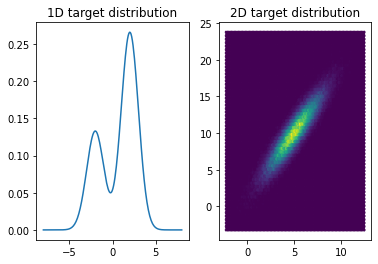

In [36]:
rng_key = jax.random.PRNGKey(42)
num_iterations = 500

target_1d = NormalMixture(jnp.array([1 / 3, 2 / 3]),
                          jnp.array([-2., 2.]), jnp.array([1., 1.]))

target_2d_dist = MultivariateNormal(loc=jnp.array([5., 10.]), covariance_matrix=[[3., 5.], [5., 10.]])

fig, axs = plt.subplots(1, 2)

target_1d.sample(rng_key, (10_000,))

x = jnp.linspace(-8, 8., 200)
axs[0].plot(x, jnp.exp(target_1d.log_prob(x)), label='target_dist')
axs[0].set_title('1D target distribution')

axs[1].hexbin(*target_2d_dist.sample(rng_key, (100_000,)).T)
axs[1].set_title('2D target distribution')
fig.show()



## Norm Kernels
For our purposes normed kernels are the form $\mathbb{R}^d \rightarrow \mathbb{R}$. We will use $<x,x'>$ to denote
the inner product.

### IMQ Kernel
The Inverse Multi Quadratic (IMQ) kernel is given by $k(x,x') = \left(c^2 + |\!|x-x'|\!|^2_2\right)^\beta$. It is known
that we must $-1<\beta<0$ and $c>0$ for KSD to converge. _With our current understanding of SVGD
this is the recommended kernel to use_!

### Linear Kernel
The Linear kernel is given by $k(x,x') = <x,x'> + 1$. The fix point of SVGD will exactly match the first (mean) and
second (variance) moment of a multivariate Gaussian when using the linear kernel. This is a property that does not hold
for the Gaussian Radial-Basis-Function (RBF) kernel.

### RBF Kernel
The Gaussian Radial-Basis-Function (RBF) kernel is given by $k(x,x')=\exp\left(-1/h|\!|x-x'|\!|_2^2\right)$. $h$ is
the bandwidth, when $h \rightarrow 0$ the repulsive force of Stein force will vanish causing particles to collapse to a
single mode.

### Random Feature Kernel
The random feature kernel use a random subset of features to compute the kernel. The advantage over a universal kernels
$k'$ is that with $n$ particles at most $n$ function basis of $k'$ can be used, even if $k'(x,x')$ has infinite rank.

### Mixture Kernel
The mixture kernel is the weight average of n kernels $k_0,...,k_n$. The only restriction is that kernels $k_i$ be of
same type (i.e. norm, vector or matrix). So the mixture kernel is strictly speaking not just a norm kernel. However, the
notion (and usage) trivially extends from a mixture of norm kernels, so we will stick with these in this tutorial.

In [26]:
kernels_fns = {'rbf_kernel': kernels.RBFKernel(),  # The kernels come default values informed by literature!
               'linear_kernel': kernels.LinearKernel(),
               'random_kernel': kernels.RandomFeatureKernel(),
               'imq_kernel': kernels.IMQKernel(),
               'mixture_kernel': kernels.MixtureKernel([0.5, 0.5],
                                                       [kernels.LinearKernel(),
                                                        kernels.RandomFeatureKernel()])}


def model():
    numpyro.sample('x', target_1d)  # 1/3 N(-2,1) + 2/3 N(2,1)

Rbf Kernel:

Stein 1.9072: 100%|██████████| 500/500 [00:03<00:00, 150.76it/s]


Linear Kernel:

Stein 2.2656: 100%|██████████| 500/500 [00:01<00:00, 459.67it/s]


Random Kernel:

Stein 1.8873: 100%|██████████| 500/500 [00:10<00:00, 49.64it/s]


Imq Kernel:

Stein 1.9319: 100%|██████████| 500/500 [00:01<00:00, 362.04it/s]


Matrix Kernel:

Stein 2.1155: 100%|██████████| 500/500 [00:10<00:00, 48.51it/s]


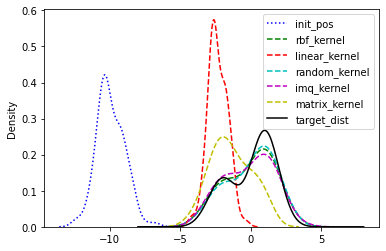

In [35]:
colors = iter(('b', 'g', 'r', 'c', 'm', 'y', 'k'))
first = True
for label, kernel_fn in kernels_fns.items():
    guide = AutoDelta(model)
    init_strategy = init_with_noise(init_to_value(values={'x_auto_loc': -10.}),
                                    noise_scale=1.0)  # Particles are initialized at -10

    print(label.replace('_', ' ').title(), end=':')
    color = next(colors)
    svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.), Trace_ELBO(),
                 kernel_fn, init_strategy=init_strategy, num_particles=100)
    if first:
        state = svgd.init(rng_key)

        sns.kdeplot(x=svgd.get_params(state)['x_auto_loc'], label=f'init_pos', linestyle='dotted', color=color)
        first = False
        color = next(colors)

    state, _ = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
    sns.kdeplot(x=svgd.get_params(state)['x_auto_loc'], label=label, linestyle='dashed', color=color)

x = jnp.linspace(-8, 8., 200)
plt.plot(x, jnp.exp(target_1d.log_prob(x)), label='target_dist', color=next(colors))
plt.legend()
plt.show()

In [24]:
def model():
    numpyro.sample('x', target_2d_dist)


## Vector Kernels

## IMG Vector Kernel

### RBF Vector Kernel

In [ ]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(),
             kernels.RBFKernel(mode='vector'),
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)
init_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
rbf_kernel_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

In [ ]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), Trace_ELBO(), kernels.GraphicalKernel(),
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)
svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])
graphical_kernel_loc = svgd.get_params(svgd_state)['x_auto_loc'].T

In [ ]:
fig, axs = plt.subplots(ncols=3)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.kdeplot(*init_loc, ax=axs[0])
    axs[0].set_title('Initial')
    sns.kdeplot(*rbf_kernel_loc, ax=axs[1])
    axs[1].scatter(*rbf_kernel_loc.mean(1).copy())
    axs[1].set_title('RBF Kernel')
    sns.kdeplot(*graphical_kernel_loc, ax=axs[2])
    axs[2].set_title('Graphical Kernel')

fig.show()

## Matrix Kernels

### Graphical Kernel

### RBF Matrix Kernel
